In [ ]:
import zipfile
import os
print(os.listdir())

['.config', '5flowers.zip', 'sample_data']


In [ ]:
!unzip -t 5flowers.zip

Archive:  5flowers.zip
    testing: daisy/100080576_f52e8ee070_n.jpg   OK
    testing: daisy/10140303196_b88d3d6cec.jpg   OK
    testing: daisy/10172379554_b296050f82_n.jpg   OK
    testing: daisy/10172567486_2748826a8b.jpg   OK
    testing: daisy/10172636503_21bededa75_n.jpg   OK
    testing: daisy/102841525_bd6628ae3c.jpg   OK
    testing: daisy/10300722094_28fa978807_n.jpg   OK
    testing: daisy/1031799732_e7f4008c03.jpg   OK
    testing: daisy/10391248763_1d16681106_n.jpg   OK
    testing: daisy/10437754174_22ec990b77_m.jpg   OK
    testing: daisy/10437770546_8bb6f7bdd3_m.jpg   OK
    testing: daisy/10437929963_bc13eebe0c.jpg   OK
    testing: daisy/10466290366_cc72e33532.jpg   OK
    testing: daisy/10466558316_a7198b87e2.jpg   OK
    testing: daisy/10555749515_13a12a026e.jpg   OK
    testing: daisy/10555815624_dc211569b0.jpg   OK
    testing: daisy/10555826524_423eb8bf71_n.jpg   OK
    testing: daisy/10559679065_50d2b16f6d.jpg   OK
    testing: daisy/105806915_a9c13e2106_n.jpg   

In [ ]:
zip_path = "5flowers.zip"
extract_path = "flowers"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
folder = []
for f in os.listdir(extract_path):
    if os.path.isdir(os.path.join(extract_path, f)):
        folder.append(f)
print(folder)

['sunflower', 'dandelion', 'rose', 'daisy', 'tulip']


Import các thư viện cần thiết


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.image import imread
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.mobilenet_v2 import preprocess_input


import tensorflow as tf
import random as rn


# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [ ]:
classes = ['daisy','dandelion',  'rose', 'sunflower', 'tulip']

In [ ]:
input_shape = (256,256)
path = extract_path
for flower_class in classes:
    class_path = os.path.join(path, flower_class)
    max_values = []
    min_values = []
    for image in os.listdir(class_path):
        img = imread(os.path.join(class_path, image))
        max_val = img.max()
        min_val = img.min()
        max_values.append(max_val)
        min_values.append(min_val)
    max_class_val = max(max_values)
    min_class_val = min(min_values)
    print("***************************")
    print(f"Class: {flower_class}")
    print(f"Max value: {max_class_val}")
    print(f"Min value: {min_class_val}")

***************************
Class: daisy
Max value: 255
Min value: 0
***************************
Class: dandelion
Max value: 255
Min value: 0
***************************
Class: rose
Max value: 255
Min value: 0
***************************
Class: sunflower
Max value: 255
Min value: 0
***************************
Class: tulip
Max value: 255
Min value: 0


In [ ]:
batch_size = 64
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=input_shape,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=input_shape,
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = train_ds.map(lambda x,y: (x/255, y))
val_ds = val_ds.map(lambda x,y: (x/255, y))
image_batch, labels_batch = next(iter(train_ds)) #This is how you read image batches, each batch contains 64 images and 64 related labels
first_image = image_batch[0]

In [ ]:
input_shape =  (256,256,3) #Add extra dimension "3" because it represent RGB(Colored Image)
num_classes = len(classes) # Changed class_names to classes
num_classes

cnn_model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),

    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),   # chống overfit sớm

    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    # Dropout(0.3),  # bật thêm nếu muốn aggressive dropout

    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    # Dropout(0.3),  # bật thêm nếu muốn aggressive dropout

    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),   # fully connected thường overfit mạnh
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,443,749 (5.51 MB)

 Trainable params: 1,443,621 (5.51 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history_cnn = cnn_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            verbose=1
        )
    ]
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 385s 7s/step - accuracy: 0.3077 - loss: 1.5454 - val_accuracy: 0.3650 - val_loss: 1.4194 - learning_rate: 0.0030
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.4645 - loss: 1.2307 - val_accuracy: 0.3071 - val_loss: 1.8346 - learning_rate: 0.0030
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 0.5070 - loss: 1.1880 - val_accuracy: 0.4461 - val_loss: 1.6344 - learning_rate: 0.0030
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 382s 7s/step - accuracy: 0.5758 - loss: 1.0451 - val_accuracy: 0.5481 - val_loss: 1.1102 - learning_rate: 0.0030
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - accuracy: 0.6181 - loss: 0.9905 - val_accuracy: 0.5041 - val_loss: 1.3109 - learning_rate: 0.0030
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 401s 7s/step - accuracy: 0.6315 - loss: 0.9182 - val_accuracy: 0.6605 - val_loss: 0.9072 - learning_rate: 0.0030
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 362s 7s/step - accuracy: 0.6930 - loss: 0.8228 - val_acc

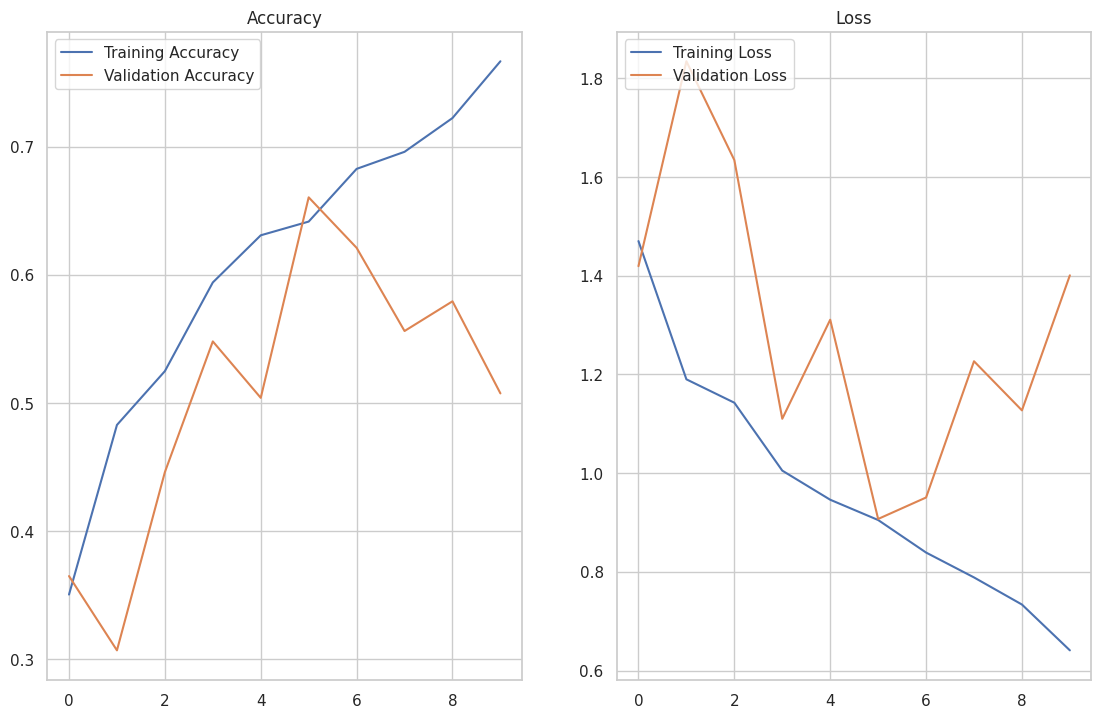

In [ ]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss')
plt.show()

Transfer Learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=20) #increased the patience of early stoping
MobileNetV2_model = Sequential()

pretrained_model = MobileNetV2(include_top=False,
                   input_shape=(256, 256, 3),
                   pooling='avg',
                   weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

MobileNetV2_model.add(pretrained_model)
MobileNetV2_model.add(Flatten())
# ANN
MobileNetV2_model.add(Dense(512, activation='relu'))
MobileNetV2_model.add(Dense(256, activation='relu'))
MobileNetV2_model.add(Dropout(0,2))

MobileNetV2_model.add(Dense(32, activation='relu'))



MobileNetV2_model.add(Dense(num_classes, activation='softmax'))

MobileNetV2_model.compile(optimizer=Adam(learning_rate=0.003),
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                          metrics=['accuracy'])

MobileNetV2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,053,573 (11.65 MB)

 Trainable params: 795,589 (3.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
MobileNetV2_model_results = MobileNetV2_model.fit(train_ds, epochs=10,
                             validation_data=val_ds,
                             callbacks=[early_stop])

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - accuracy: 0.6887 - loss: 0.8058 - val_accuracy: 0.7984 - val_loss: 0.5580
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.8913 - loss: 0.2999 - val_accuracy: 0.8656 - val_loss: 0.3674
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.9302 - loss: 0.1921 - val_accuracy: 0.8818 - val_loss: 0.3570
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 353s 5s/step - accuracy: 0.9581 - loss: 0.1265 - val_accuracy: 0.8841 - val_loss: 0.3656
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.9687 - loss: 0.0890 - val_accuracy: 0.8980 - val_loss: 0.4014
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.9645 - loss: 0.0927 - val_accuracy: 0.8725 - val_loss: 0.4817
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.9751 - loss: 0.0742 - val_accuracy: 0.8864 - val_loss: 0.4742
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.9862 - loss: 0.0364 - val_accuracy: 0.8899 - v

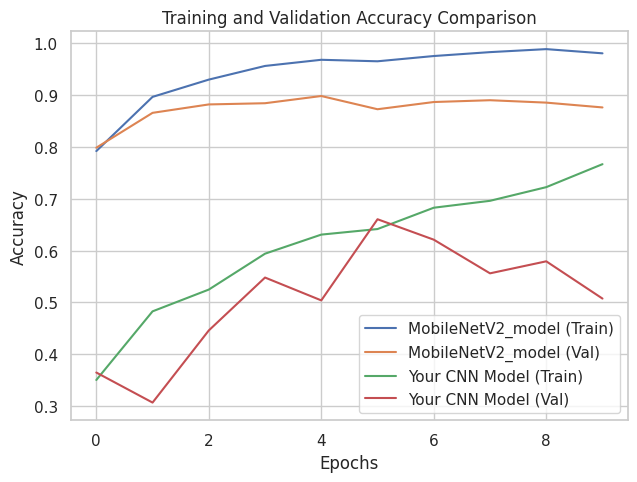

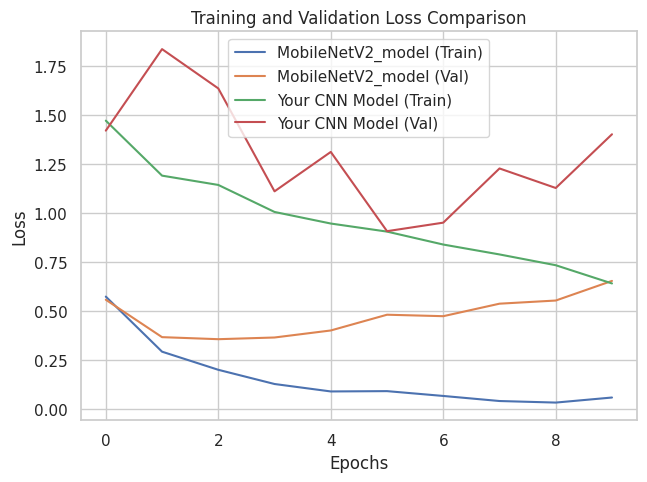

In [ ]:
plt.plot(MobileNetV2_model_results.history['accuracy'], label='MobileNetV2_model (Train)')
plt.plot(MobileNetV2_model_results.history['val_accuracy'], label='MobileNetV2_model (Val)')
plt.plot(history_cnn.history['accuracy'], label='Your CNN Model (Train)') # Changed history to history_cnn
plt.plot(history_cnn.history['val_accuracy'], label='Your CNN Model (Val)') # Changed history to history_cnn
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()

plt.plot(MobileNetV2_model_results.history['loss'], label='MobileNetV2_model (Train)')
plt.plot(MobileNetV2_model_results.history['val_loss'], label='MobileNetV2_model (Val)')
plt.plot(history_cnn.history['loss'], label='Your CNN Model (Train)') # Changed history to history_cnn
plt.plot(history_cnn.history['val_loss'], label='Your CNN Model (Val)') # Changed history to history_cnn
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ======================
# Build MobileNetV3 model
# ======================
MobileNetV3_model = Sequential()

pretrained_model = MobileNetV3Large(
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg',
    weights='imagenet'
)

# Freeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

MobileNetV3_model.add(pretrained_model)
MobileNetV3_model.add(Flatten())

# ANN head
MobileNetV3_model.add(Dense(512, activation='relu'))
MobileNetV3_model.add(Dense(256, activation='relu'))
MobileNetV3_model.add(Dropout(0.2))

MobileNetV3_model.add(Dense(32, activation='relu'))
MobileNetV3_model.add(Dense(num_classes, activation='softmax'))

# Compile
MobileNetV3_model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

MobileNetV3_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,628,101 (13.84 MB)

 Trainable params: 631,749 (2.41 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
MobileNetV3_model_results = MobileNetV3_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stop]
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.2392 - loss: 1.6338 - val_accuracy: 0.2735 - val_loss: 1.5931
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.3016 - loss: 1.5667 - val_accuracy: 0.3163 - val_loss: 1.5557
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.3266 - loss: 1.5287 - val_accuracy: 0.3523 - val_loss: 1.5182
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.3502 - loss: 1.5043 - val_accuracy: 0.3511 - val_loss: 1.5234
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 319s 5s/step - accuracy: 0.3369 - loss: 1.5237 - val_accuracy: 0.3650 - val_loss: 1.5103
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.3636 - loss: 1.4827 - val_accuracy: 0.3720 - val_loss: 1.4638
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.3790 - loss: 1.4765 - val_accuracy: 0.3778 - val_loss: 1.4556
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.3655 - loss: 1.4795 - val_accuracy: 0.3870 - v

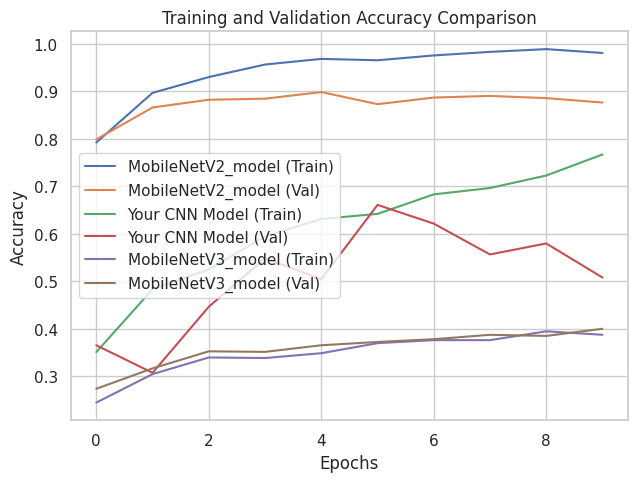

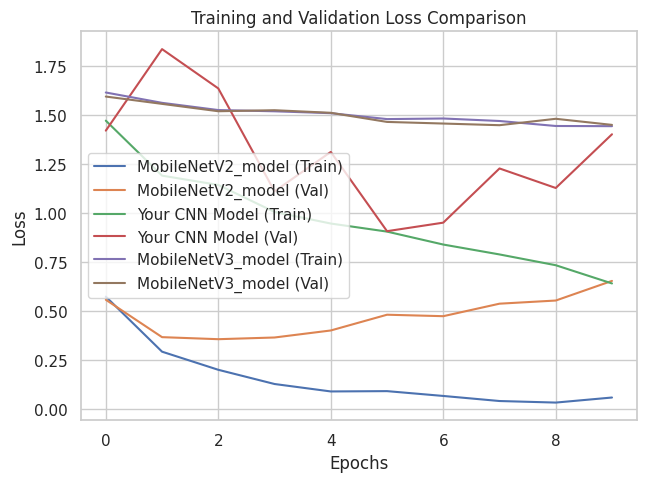

In [ ]:
plt.plot(MobileNetV2_model_results.history['accuracy'], label='MobileNetV2_model (Train)')
plt.plot(MobileNetV2_model_results.history['val_accuracy'], label='MobileNetV2_model (Val)')
plt.plot(history_cnn.history['accuracy'], label='Your CNN Model (Train)') # Changed history to history_cnn
plt.plot(history_cnn.history['val_accuracy'], label='Your CNN Model (Val)') # Changed history to history_cnn
plt.plot(MobileNetV3_model_results.history['accuracy'], label='MobileNetV3_model (Train)')
plt.plot(MobileNetV3_model_results.history['val_accuracy'], label='MobileNetV3_model (Val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()

plt.plot(MobileNetV2_model_results.history['loss'], label='MobileNetV2_model (Train)')
plt.plot(MobileNetV2_model_results.history['val_loss'], label='MobileNetV2_model (Val)')
plt.plot(history_cnn.history['loss'], label='Your CNN Model (Train)') # Changed history to history_cnn
plt.plot(history_cnn.history['val_loss'], label='Your CNN Model (Val)') # Changed history to history_cnn
plt.plot(MobileNetV3_model_results.history['loss'], label='MobileNetV3_model (Train)')
plt.plot(MobileNetV3_model_results.history['val_loss'], label='MobileNetV3_model (Val)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lưu model vào Drive
# Lưu CNN
cnn_model.save("/content/drive/MyDrive/cnn_model.h5")

# Lưu MobileNetV2
MobileNetV2_model.save("/content/drive/MyDrive/mobilenetv2_model.h5")

# Lưu MobileNetV3
MobileNetV3_model.save("/content/drive/MyDrive/mobilenetv3_model.h5")